In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# import rpy2
from scipy.stats import beta, combine_pvalues
from statsmodels.sandbox.stats.multicomp import multipletests
%matplotlib inline

plt.rcParams['figure.figsize'] = (12.0, 10.0)

# Multiple Hypothesis Testing!


## aka "Plenty of P-Values"

### by Zane Blanton

 #### Data Scientist in Marketplace at trivago

# Standard Hypothesis Testing

- We set an $\alpha$ (False Error Rate) of 0.05.
- Thus, only five percent of null hypotheses that we test are actually rejected.
- We hope that analyses delivered in this way are for the most part are valid.

## How we hope this works


In [4]:
total_null = 500
total_alt = 500

rejected_null = total_null * 0.05
rejected_alt = total_alt * 0.95


In [5]:
hypothesis_df = pd.DataFrame({'null hypotheses': [total_null, total_null - rejected_null, 0],
                          'rejected nulls': [0, rejected_null, rejected_null],
                          'alt hypotheses': [total_alt, total_alt - rejected_alt, 0],
                          'rejected alts': [0, rejected_alt, rejected_alt]},
                         index=['population of hypotheses',
                                'rejected_hypotheses',
                                'only rejected hypotheses'])
hypothesis_df = hypothesis_df[['null hypotheses', 'rejected nulls', 'alt hypotheses', 'rejected alts']]
def plot_hyp_df():
    hypothesis_df.plot(kind='bar', stacked=True, color=['lightsteelblue', 'darkblue',
                                                    'wheat', 
                                                   'orange'],
               title="When we are halfway right: 95% of rejected hypotheses are alt" )
    plt.show()

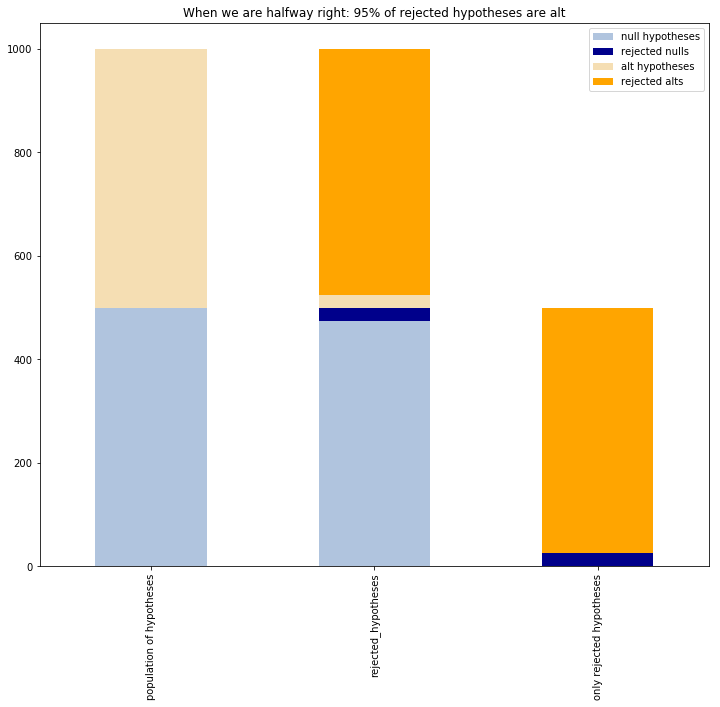

In [6]:
plot_hyp_df()

## But what if we go wild?

In [7]:
total_null = 950
total_alt = 50

rejected_null = total_null * 0.05
rejected_alt = total_alt * 0.95

In [8]:
hypothesis_df = pd.DataFrame({'null hypotheses': [total_null, total_null - rejected_null, 0],
                          'rejected nulls': [0, rejected_null, rejected_null],
                          'alt hypotheses': [total_alt, total_alt - rejected_alt, 0],
                          'rejected alts': [0, rejected_alt, rejected_alt]},
                         index=['population of hypotheses',
                                'rejected_hypotheses',
                                'only rejected hypotheses'])
hypothesis_df = hypothesis_df[['null hypotheses', 'rejected nulls', 'alt hypotheses', 'rejected alts']]
def plot_hyp_df_again():
    hypothesis_df.plot(kind='bar', stacked=True, color=['lightsteelblue', 'darkblue', 'wheat', 
                                                     'orange'],
                   title="When we're mostly wrong: 50% of rejected hypothese are alt")
    plt.show()

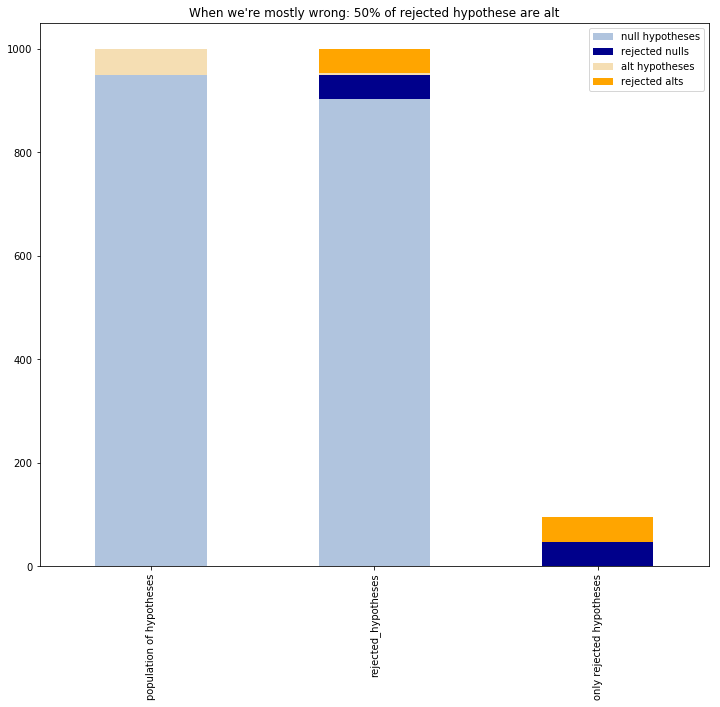

In [9]:
plot_hyp_df_again()

## And where might we encounter the second situation?
![trivago example redacted but think AB testing ](images/release-controller-screenshot.png)

## Let's make up parameters for a multiple testing situation and simulate some data

- Assume null p values distributed as Uniform(0, 1) 
- Assume alternative p values distributed as Beta(1, 100)
- This assumption means that we have a lot of power, since we're nearly guaranteed to reject our alternative hypotheses at an $\alpha$ of 0.05

In [55]:
a = 1
b = 100
x = np.arange(0, 1, 0.001)
null_distr = np.ones(1000)
alt_distr = beta(a=a, b=b).pdf(x)

In [56]:
def plot_our_p_distrs():
    plt.plot(x, null_distr)
    plt.plot(x, alt_distr)
    plt.legend(['null_distr', 'alt_distr'])
    plt.ylim((0, 15))
    plt.title('Null Versus Alternative Hypothesis P Values')
    plt.show()

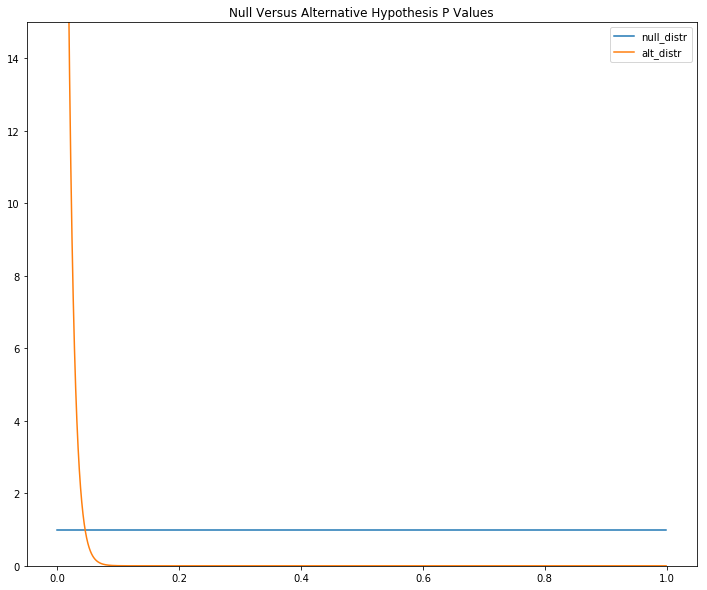

In [57]:
plot_our_p_distrs()

In [58]:
np.random.seed(118943579)

# Let's sample some p values!

But first, let's assume that 90% of the hypotheses we are testing are null.

In [59]:
total_null = 900
total_alt = 100
null_pulls = np.random.random(total_null)
alt_pulls = np.random.beta(a=a, b=b, size=total_alt)


In [1]:
def plot_sim():
    plt.hist([null_pulls, alt_pulls], bins=20,
            stacked=True)
    plt.title("Simulated P values")
    plt.legend(['null_pulls', 'alt_pulls'])
    plt.show()

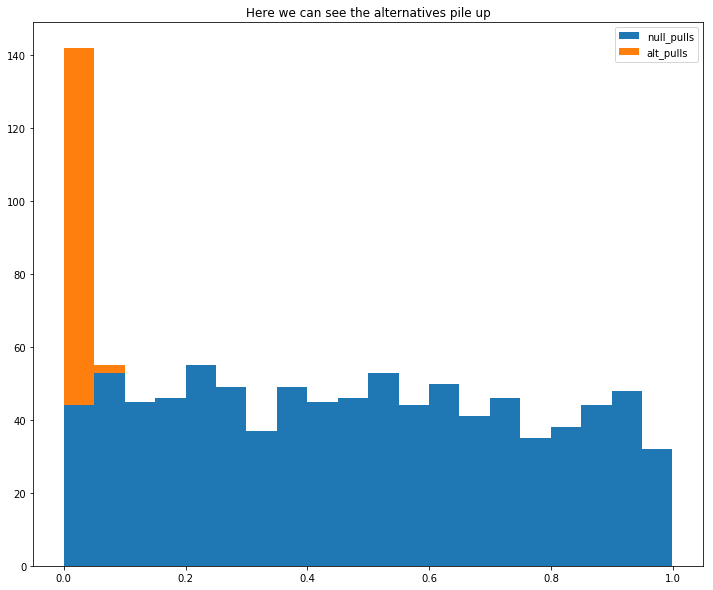

In [65]:
plot_sim()

In [66]:
def plot_sim_gray():
    plt.hist(np.concatenate([null_pulls, alt_pulls]), bins=20, color='gray')
    plt.title("But if we don't know which are which?")
    plt.show()

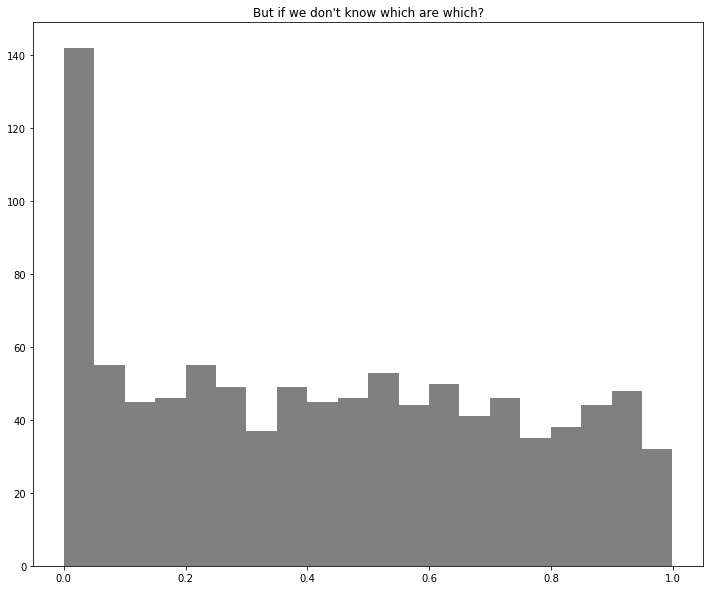

In [67]:
plot_sim_gray()

# Let's use our classic method with $\alpha$ = 0.05

In [68]:
null_pulls_rejected = null_pulls[null_pulls <= 0.05]
alt_pulls_rejected = alt_pulls[alt_pulls <= 0.05]

In [124]:
def classic_hyp_hist():
    plt.hist([null_pulls_rejected, alt_pulls_rejected], stacked=True)
    plt.legend(['null_pulls: {}'.format(len(null_pulls_rejected)),
                'alt_pulls: {}'.format(len(alt_pulls_rejected))])
    percent_alt = int(alt_pulls_rejected.shape[0] / (alt_pulls_rejected.shape[0] + null_pulls_rejected.shape[0]) * 100)
    plt.title('We End up Getting {percent_alt}% Alt Hypotheses'.format(percent_alt=percent_alt))
    plt.show()

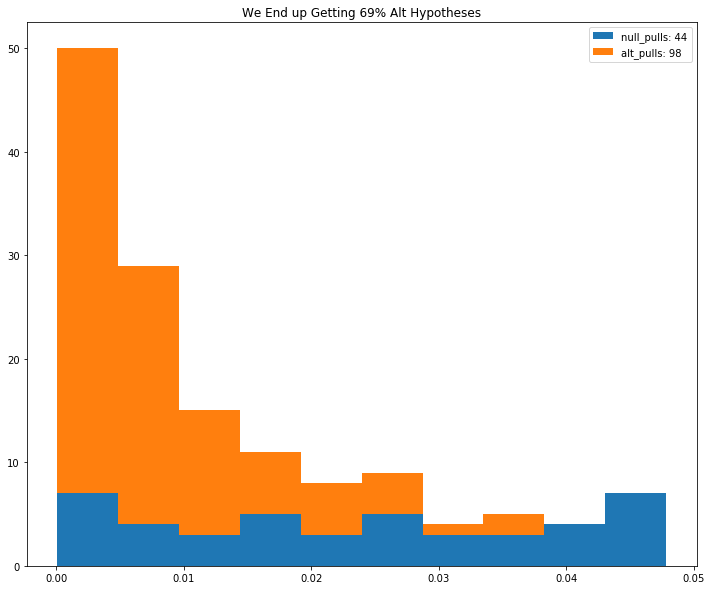

In [125]:
classic_hyp_hist()

# Bonferroni Correction


### Definition of family-wise error rate (FWER)
If any null hypothesis is rejected under the null, then we consider it a false positive.

The Bonferroni correction controls FWER by setting $\alpha = \frac{0.05}{k}$ where $k$ is the number of hypotheses we're testing.
In our case, this is $0.05 / 1000 = 0.00005$

In [72]:
print(alt_pulls[alt_pulls <= 0.05 / 1000])
print(null_pulls[null_pulls <= 0.05 / 1000])

[]
[]


In [73]:
print(alt_pulls[alt_pulls <= 0.10 / 1000])
print(null_pulls[null_pulls <= 0.10 / 1000])

[  9.82946677e-05]
[]


But somehow this is unimpressive

# If only there were another way...

# Controlling False Discovery Rate (FDR)

We can set an $\alpha$ control on the expected proportion of null hypotheses in the set of hypotheses we reject, known as the False Discovery Rate.

In [76]:
def plot_hyp_df_fdr():
    hypothesis_df.plot(kind='bar', stacked=True, color=['lightsteelblue', 'darkblue', 'wheat', 
                                                     'orange'],
                   title="Let's control the proportion of orange on the right")
    plt.show()

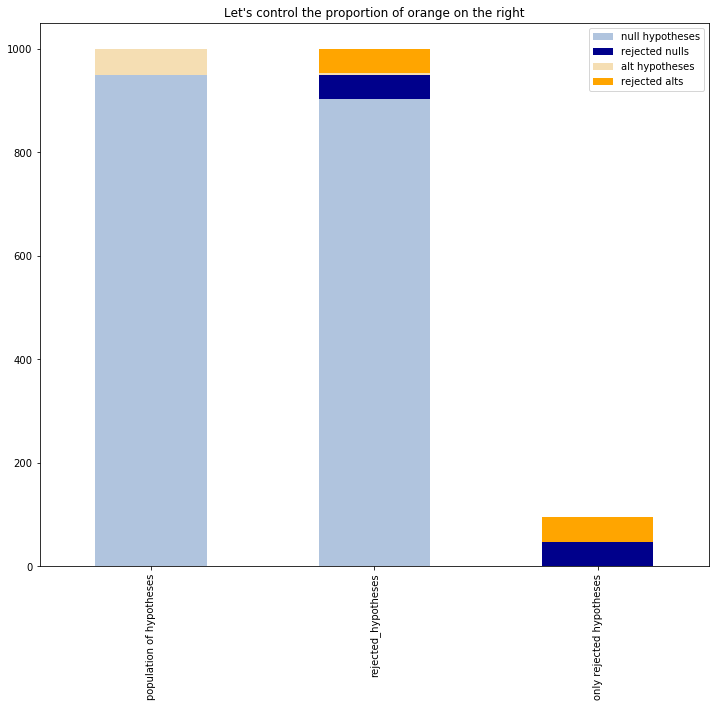

In [77]:
plot_hyp_df_fdr()

# Benjamini-Hochberg Step-up Procedure:
1. Sort all null hypotheses. The smallest p value is $p_{(1)}$, the second smallest is $p_{(2)}$, etc.
2. Set an FDR control $\alpha=0.10$
3. Then, find the largest $k$ such that $p_{(k)} \le \frac{k}{m}\alpha$.
4. Finaly, we we reject all null hypotheses $p_{(1)}, \dots, p_{(k)}$



We will accept this procedure as magic, but for those of you who are  curious, here's a link to the proof: https://statweb.stanford.edu/~candes/stats300c/Lectures/Lecture7.pdf 

# Now, let's apply this to our data

In [120]:
alpha = 0.10
null_pulls.sort()
alt_pulls.sort()
p_values_df = pd.DataFrame({'p': np.concatenate([null_pulls, alt_pulls]),
                            'case': ['null'] * total_null + ['alt'] * total_alt}).sort_values('p', ascending=True)
n = p_values_df.shape[0]
p_values_df['adjusted_alpha'] = [alpha * (k + 1) / n for k in range(n)]
p_values_df['k'] = range(1, n + 1)
p_values_to_reject = multipletests(p_values_df.p.values,
                                   alpha=alpha,
                                   method='fdr_bh')[0]
p_values_rejected = p_values_df.loc[p_values_to_reject, :].reset_index(drop=True)


def plot_stepup():
    ax = plt.subplot(111)
    p_values_df.plot(x='k', y='p', kind='scatter', marker='.', ax=ax)
    p_values_df.plot(x='k', y='adjusted_alpha', ax=ax, color='red')
    ax.set_yscale('log')
    plt.title('Step-Up Procedure: Find the last time a blue point is under red line')
    plt.xlabel('kth smallest p value')
    plt.ylabel('Log of p-value')
    plt.show()

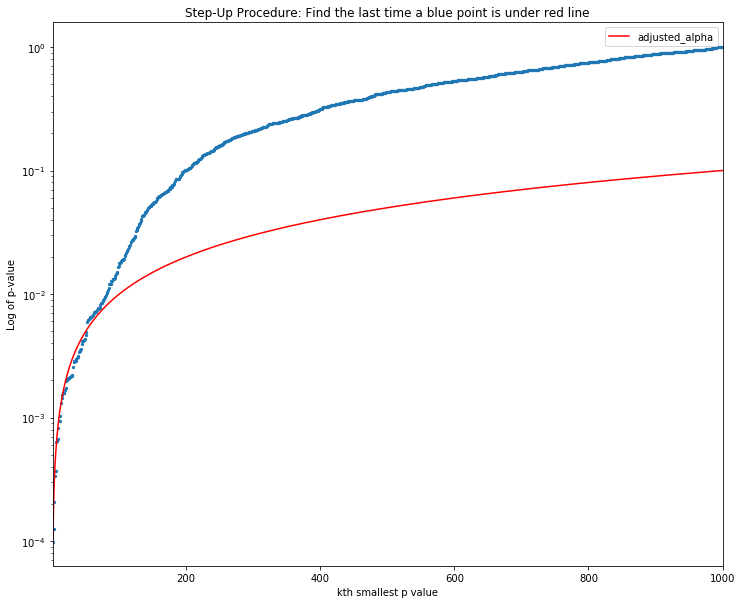

In [121]:
plot_stepup()

In [2]:
print(p_values_rejected)

NameError: name 'p_values_rejected' is not defined

In [128]:
max_p_fdr = max(p_values_df.loc[p_values_to_reject, 'p'])
def plot_stepup_hist():
    null_pulls_rejected = null_pulls[null_pulls <= max_p_fdr]
    alt_pulls_rejected = alt_pulls[alt_pulls <= max_p_fdr]
    plt.hist([null_pulls_rejected, alt_pulls_rejected], stacked=True)
    plt.legend(['null_pulls: {}'.format(len(null_pulls_rejected)),
                'alt_pulls: {}'.format(len(alt_pulls_rejected))])
    percent_alt = int(alt_pulls_rejected.shape[0] / (alt_pulls_rejected.shape[0] + null_pulls_rejected.shape[0]) * 100)
    plt.title('We End up Getting {percent_alt}% Alt Hypotheses'.format(percent_alt=percent_alt))
    plt.show()

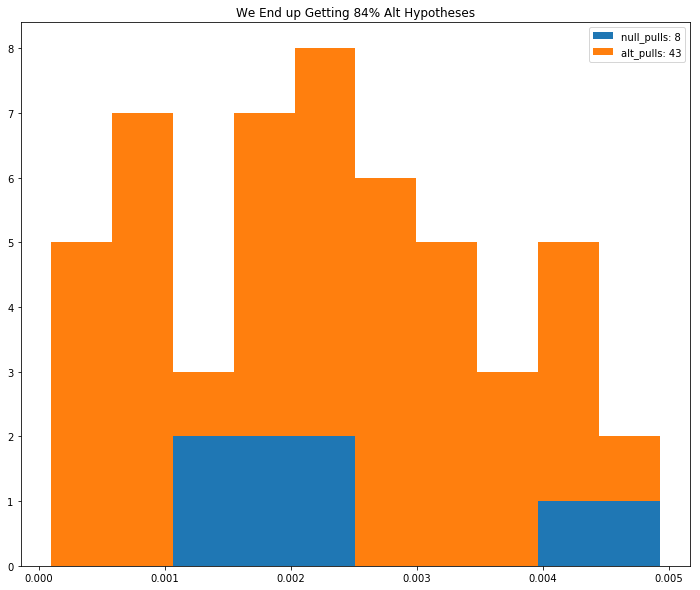

In [129]:
plot_stepup_hist()

In [148]:
def plot_all_criteria(xmax=0.10, bins=500):
    plt.hist([null_pulls, alt_pulls], bins=bins,
            stacked=True)
    plt.xlim(-0.001, xmax)
    plt.title("Lines are Bonferroni, Step-Up, and Classic Alpha")
    plt.legend(['null_pulls', 'alt_pulls'])
    plt.axvline(0.05, color='red')
    plt.axvline(max_p_fdr, color='pink')
    plt.axvline(0.05 / 1000, color='purple')
    plt.show()

# Wrap-Up 


In [4]:
plot_all_criteria(xmax=1.0, bins=40)

NameError: name 'plot_all_criteria' is not defined

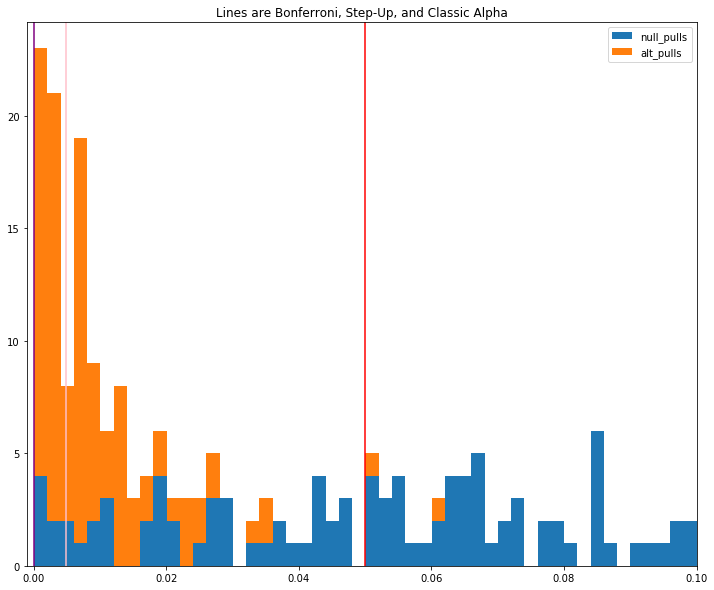

In [149]:
plot_all_criteria(xmax=0.10)

# Wrap-Up

- Traditional hypothesis testing controls our false positive rate, the rate at which we reject null hypotheses.
-  Also discussed a Family-Wise Error Rate (don't make even one mistake!) and looked at the Bonferroni correction
- We also discussed a False Discovery Rate, which is the proportion of null hypotheses in the pool of rejected hypotheses, and looked at the BH Step-Up Procedure to correct for this.

- If you had a representative set of labelled hypotheses, you could set up a loss function and optimize your cutoff based upon it


# Final note on Dependence of P Values

- FDR methodology can be extended to deal with dependence among test statistics.
- In the positively correlated case, our current controls are sufficient. 
- For the negatively correlated case, we have to reduce our p values further.

- Bonferroni adjustment covers all cases.

Of course, there are lots of other ways to deal with this problem.

Feel free to try different methods until you get the results you want! (joke)

In [28]:
help(multipletests)

Help on function multipletests in module statsmodels.stats.multitest:

multipletests(pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)
    test results and p-value correction for multiple tests
    
    
    Parameters
    ----------
    pvals : array_like
        uncorrected p-values
    alpha : float
        FWER, family-wise error rate, e.g. 0.1
    method : string
        Method used for testing and adjustment of pvalues. Can be either the
        full name or initial letters. Available methods are ::
    
        `bonferroni` : one-step correction
        `sidak` : one-step correction
        `holm-sidak` : step down method using Sidak adjustments
        `holm` : step-down method using Bonferroni adjustments
        `simes-hochberg` : step-up method  (independent)
        `hommel` : closed method based on Simes tests (non-negative)
        `fdr_bh` : Benjamini/Hochberg  (non-negative)
        `fdr_by` : Benjamini/Yekutieli (negative)
        `fdr_tsbh` : two st

## *And now it's Question Time*

# 🤔🤔🤔